Total Commissioning 99-percentile: 41788.93000000014
Discovery Latency 99-percentile: 2448.2400000000152
Read Commissioning Info Latency 99-percentile: 865.9000000000019
Pase Latency 99-percentile: 39319.95000000013



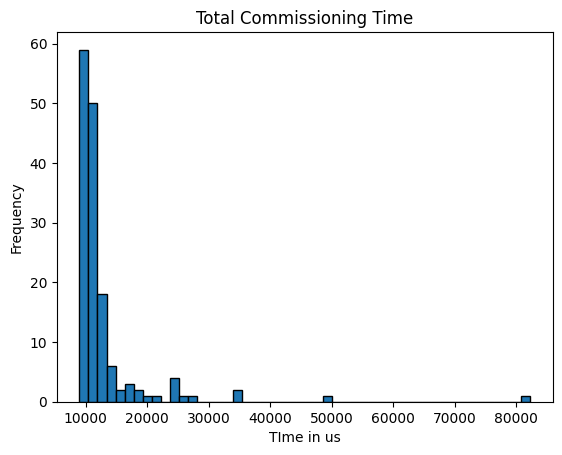

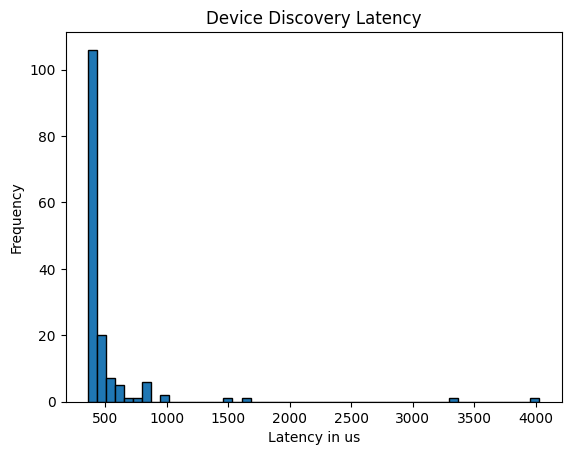

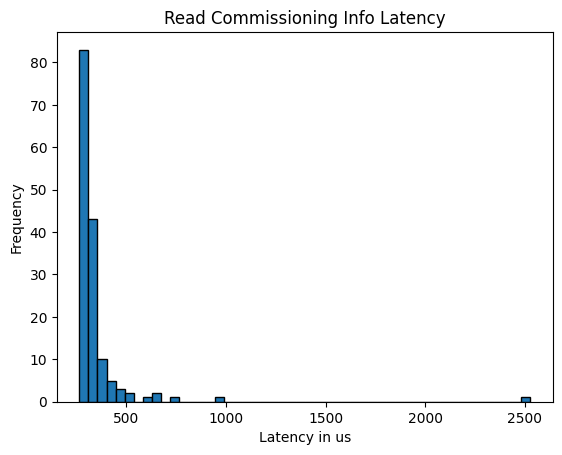

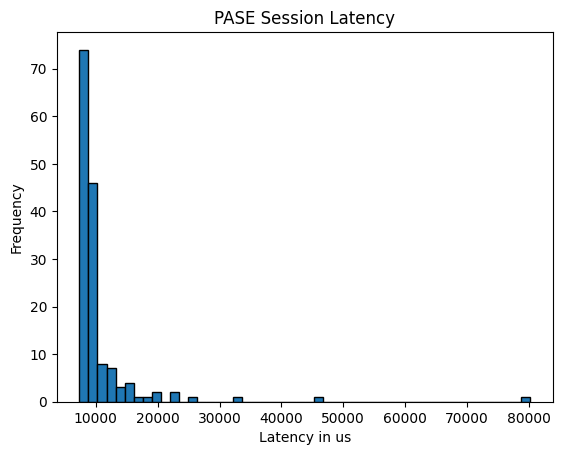

In [3]:
import os
import sys
import re
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

# if len(sys.argv) != 2:
#     print("Usage: python script.py /path/to/your/directory")
#     sys.exit(1)
    
# directory_path = sys.argv[1]

directory_path = "/Users/fwmm/Downloads/logs"



class Commissioning:
    
    date_pattern = r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d+'
    
    #step_type = [
    #    "Performing",  
    #    "Successfully"
    #]
    
    #step_name = [
    #    "ReadCommissioningInfo",
    #    "ReadCommissioningInfo2",
    #    "ArmFailSafe",
    #    "ConfigRegulatory",
    #    "ConfigureUTCTime",
    #    "SendPAICertificateRequest",
    #    "SendDACCertificateRequest",
    #    "SendAttestationRequest",
    #    "AttestationVerification",
    #    "SendOpCertSigningRequest",
    #    "ValidateCSR",
    #    "GenerateNOCChain",
    #    "SendTrustedRootCert",
    #    "SendNOC",
    #    "FindOperational",
    #    "SendComplete",
    #    "Cleanup",       
    #]

    stages = {
        'discovery': {'begin': '(?=.*Internal\\ Control\\ start\\ simulated\\ app)',
                      'end': '(?=.*Discovered\\ Device)'},
        'readCommissioningInfo': {'begin': '(?=.*ReadCommissioningInfo)(?=.*Performing)',
                      'end': '(?=.*ReadCommissioningInfo)(?=.*Successfully)'},
        'PASE': {'begin': '(?=.*PBKDFParamRequest)',
                 'end': "(?=.*'kEstablishing'\\ \\-\\->\\ 'kActive')"},
        'cleanup': {'begin': '(?=.*Cleanup)(?=.*Performing)',
                    'end': '(?=.*Cleanup)(?=.*Successfully)'}
    }
    
    def __init__(self):
        self.commissioning = {}
        
    def __repr__(self):
        return self.commissioning.__repr__()
    
    
    def add_event(self, line:str):       
        for stage, patterns in self.stages.items():
            begin = None
            end = None
            if not(stage in self.commissioning):
                self.commissioning[stage] = {}
                
            #pattern_begin = f"(?=.*{re.escape(stage)})(?=.*{re.escape(self.step_type[0])})"
            if re.search(patterns['begin'], line) is not None:  
                match = re.findall(self.date_pattern, line)
                if match[0]:
                    begin = datetime.strptime(match[0], '%Y-%m-%d %H:%M:%S.%f')
                    if (stage == "discovery"):
                        self.commissioning["begin"] = begin
                    self.commissioning[stage]["begin"] = begin
                    
            #pattern_end = f"(?=.*{re.escape(stage)})(?=.*{re.escape(self.step_type[1])})"        
            if re.search(patterns['end'], line) is not None:
                match = re.findall(self.date_pattern, line)
                if match[0]:
                    end = datetime.strptime(match[0], '%Y-%m-%d %H:%M:%S.%f')
                    if (stage == "cleanup"):
                        self.commissioning["end"] = end
                    self.commissioning[stage]["end"] = end

# List all files in the specified directory
files = os.listdir(directory_path)

commissioning_list = []

for file_name in files:
    file_path = os.path.join(directory_path, file_name)
    commissioning_obj: Commissioning = None
    if os.path.isfile(file_path):
        # Open and read the file
        with open(file_path, 'r') as file:
            for line in file:
                line = line.strip()
                pattern_begin = f"(?=.*{re.escape('Begin Commission')})"
                pattern_end = f"(?=.*{re.escape('Internal Control stop simulated app')})"
                if re.search(pattern_begin, line) is not None:
                    commissioning_obj = Commissioning()
                    continue
                    
                
                elif re.search(pattern_end, line) is not None:
                    if commissioning_obj is not None:
                        commissioning_list.append(commissioning_obj)
                    continue
                    
                elif commissioning_obj is not None:
                    commissioning_obj.add_event(line)
                    
durations = []
read_durations = []
discovery_durations = []
PASE_durations = []
for commissioning in commissioning_list:
    begin = int(commissioning.commissioning["begin"].timestamp() * 1000000)
    end = int(commissioning.commissioning["end"].timestamp() * 1000000)
    
    read_begin = int(commissioning.commissioning["readCommissioningInfo"]["begin"].timestamp() * 1000000)
    read_end = int(commissioning.commissioning["readCommissioningInfo"]["end"].timestamp() * 1000000)

    discovery_begin = int(commissioning.commissioning["discovery"]["begin"].timestamp() * 1000000)
    discovery_end = int(commissioning.commissioning["discovery"]["end"].timestamp() * 1000000)

    PASE_begin = int(commissioning.commissioning["PASE"]["begin"].timestamp() * 1000000)
    PASE_end = int(commissioning.commissioning["PASE"]["end"].timestamp() * 1000000)
    
    duration = end - begin #+ random.randint(1, 20)
    read_duration = read_end - read_begin
    discovery_duration = discovery_end - discovery_begin
    PASE_duration = PASE_end - PASE_begin
    #print(f"Commission duration: {duration}")
    #print(f"ReadCommissioningInfo duration: {read_duration}")
    #break # Just get  one sample
    durations.append(duration)
    read_durations.append(read_duration)
    discovery_durations.append(discovery_duration)
    PASE_durations.append(PASE_duration)
    #read_durations += read_duration

np_durations = np.array(durations)
durations_99p = np.percentile(np_durations, 99)
np_discoveries = np.array(discovery_durations)
discoveries_99p = np.percentile(np_discoveries, 99)
np_reads = np.array(read_durations)
reads_99p = np.percentile(np_reads, 99)
np_pases = np.array(PASE_durations)
pases_99p = np.percentile(np_pases, 99)
print(f"Total Commissioning 99-percentile: {durations_99p}")
print(f"Discovery Latency 99-percentile: {discoveries_99p}")
print(f"Read Commissioning Info Latency 99-percentile: {reads_99p}")
print(f"Pase Latency 99-percentile: {pases_99p}\n")

plt.hist(durations, bins=50, edgecolor='black')
plt.xlabel('TIme in us')
plt.ylabel('Frequency')
plt.title('Total Commissioning Time')

# Show the plot
plt.show()

plt.hist(discovery_durations, bins=50, edgecolor='black')
plt.xlabel('Latency in us')
plt.ylabel('Frequency')
plt.title('Device Discovery Latency')

# Show the plot
plt.show()

plt.hist(read_durations, bins=50, edgecolor='black')
plt.xlabel('Latency in us')
plt.ylabel('Frequency')
plt.title('Read Commissioning Info Latency')

# Show the plot
plt.show()

plt.hist(PASE_durations, bins=50, edgecolor='black')
plt.xlabel('Latency in us')
plt.ylabel('Frequency')
plt.title('PASE Session Latency')

# Show the plot
plt.show()
